In [25]:
#### import my modules

import sys
from pathlib import Path
sys.path.append(str(Path("..").resolve()))

from data_handling import load_measurements_txt, MeasurementDataset, MeasurementLoader


#### general imports

import csv
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

data_dir = Path("measurements")
print(f"Data resides in: {data_dir.resolve()}")

Data resides in: /Users/Tonni/Desktop/master-code/neural-quantum-tomo/experiments_merge/tfim_dynamics/measurements


In [26]:
# CELL 3 — model (ConditionalRBM) — expects batch = (values, bases, system_params)

class Conditioner(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int, width: int):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.cond_dim = cond_dim

        self.fc1 = nn.Linear(cond_dim, width)
        self.fc2 = nn.Linear(width, 2 * (num_visible + num_hidden))

    def forward(self, cond: torch.Tensor):
        """
        cond: (B, cond_dim)
        """
        if cond.dim() == 1:
            cond = cond.view(-1, self.cond_dim)
        elif cond.dim() == 2 and cond.size(1) == self.cond_dim:
            pass
        else:
            raise ValueError(
                f"Conditioner: expected shape (B, {self.cond_dim}), got {tuple(cond.shape)}"
            )

        x = torch.tanh(self.fc1(cond))
        x = self.fc2(x)

        N, H = self.num_visible, self.num_hidden
        gamma_b, beta_b, gamma_c, beta_c = torch.split(x, [N, N, H, H], dim=-1)
        return gamma_b, beta_b, gamma_c, beta_c


class ConditionalRBM(nn.Module):
    """
    Conditional RBM with per-sample conditioning vector.

    Batch format from MeasurementLoader:
        values        : (B, N) uint8
        bases         : list[Tuple[str,...]]  (ignored here, but available)
        system_params : (B, cond_dim) float32

    We use system_params as input to the Conditioner.
    """

    def __init__(
            self,
            num_visible: int,
            num_hidden: int,
            cond_dim: int,
            conditioner_width: int = 64,
            k: int = 1,
            T: float = 1.0,
    ):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.cond_dim = cond_dim
        self.k = k
        self.T = T

        self.W = nn.Parameter(torch.empty(num_visible, num_hidden))
        self.b = nn.Parameter(torch.zeros(num_visible))
        self.c = nn.Parameter(torch.zeros(num_hidden))

        nn.init.normal_(self.W, mean=0.0, std=0.01)

        self.conditioner = Conditioner(
            num_visible=num_visible,
            num_hidden=num_hidden,
            cond_dim=cond_dim,
            width=conditioner_width,
        )

    @staticmethod
    def _free_energy(
            v: torch.Tensor,
            W: torch.Tensor,
            b: torch.Tensor,
            c: torch.Tensor,
    ) -> torch.Tensor:
        """
        v: (B,N)
        W: (N,H)
        b: (B,N) or (N,)
        c: (B,H) or (H,)
        """
        if b.dim() == 1:
            b = b.unsqueeze(0).expand_as(v)
        h_arg = v @ W
        if c.dim() == 1:
            c = c.unsqueeze(0).expand(h_arg.shape[0], -1)

        term1 = -(v * b).sum(dim=-1)
        term2 = F.softplus(h_arg + c).sum(dim=-1)
        return term1 - term2

    @staticmethod
    def _sample_bernoulli(probs: torch.Tensor, gen: torch.Generator) -> torch.Tensor:
        noise = torch.rand(
            probs.shape,
            generator=gen,
            device=probs.device,
            dtype=probs.dtype,
        )
        return (noise < probs).to(probs.dtype)

    def _gibbs_step_T(
            self,
            v: torch.Tensor,
            b_mod: torch.Tensor,
            c_mod: torch.Tensor,
            T: float,
            gen: torch.Generator,
    ):
        # Sample h | v
        logits_h = (v @ self.W + c_mod) / T
        p_h = torch.sigmoid(logits_h)
        h = self._sample_bernoulli(p_h, gen)

        # Sample v | h
        logits_v = (h @ self.W.t() + b_mod) / T
        p_v = torch.sigmoid(logits_v)
        v = self._sample_bernoulli(p_v, gen)
        return v

    def forward(
            self,
            batch: Tuple[torch.Tensor, List[Tuple[str, ...]], Optional[torch.Tensor]],
            aux_vars: Dict[str, Any],
    ):
        """
        batch:
            values        : (B, N), uint8
            bases         : list[Tuple[str,...]]  (ignored)
            system_params : (B, cond_dim), float32

        aux_vars:
            gen          : torch.Generator for Gibbs sampling
            l2_strength  : float, L2 penalty on deviation (b_mod, c_mod) from base (b, c)
        """
        values, bases, cond = batch  # bases currently unused

        if cond is None:
            raise ValueError("ConditionalRBM expects non-None system_params as conditioning vector.")

        gen: torch.Generator = aux_vars.get("gen", torch.Generator().manual_seed(0))
        l2_strength: float = float(aux_vars.get("l2_strength", 0.0))

        v_data = values.float()
        cond = cond.to(v_data.device, dtype=v_data.dtype)

        # Per-sample effective biases from conditioner
        gamma_b, beta_b, gamma_c, beta_c = self.conditioner(cond)
        b_mod = (1.0 + gamma_b) * self.b.unsqueeze(0) + beta_b
        c_mod = (1.0 + gamma_c) * self.c.unsqueeze(0) + beta_c

        # Negative phase: persistent or fresh chain; here fresh per batch
        v_model = (torch.rand(v_data.shape, generator=gen, device=v_data.device) < 0.5).float()
        for _ in range(self.k):
            v_model = self._gibbs_step_T(v_model, b_mod, c_mod, self.T, gen)
        v_model = v_model.detach()

        fe_data = self._free_energy(v_data, self.W, b_mod, c_mod)
        fe_model = self._free_energy(v_model, self.W, b_mod, c_mod)

        fe_delta = fe_data - fe_model
        fe_mean = fe_delta.mean()
        fe_std = fe_delta.std(unbiased=False)

        # Small regularizer: keep conditioner-modulated biases near base biases
        l2_regularization = (
                (self.b.unsqueeze(0) - b_mod).pow(2).sum()
                + (self.c.unsqueeze(0) - c_mod).pow(2).sum()
        )

        loss = fe_mean + l2_strength * l2_regularization

        aux_out = {
            "free_energy_mean": fe_mean.detach(),
            "free_energy_std": fe_std.detach(),
        }
        return loss, aux_out

    @torch.no_grad()
    def generate(
            self,
            cond: torch.Tensor,
            T_schedule: torch.Tensor,
            gen: torch.Generator,
    ) -> torch.Tensor:
        """
        Generate samples given conditioning vector(s).

        cond       : (B, cond_dim)
        T_schedule : scalar or (K,) schedule
        """
        if cond.dim() == 1:
            cond = cond.view(-1, self.cond_dim)
        cond = cond.to(next(self.parameters()).device, dtype=torch.float32)

        gamma_b, beta_b, gamma_c, beta_c = self.conditioner(cond)
        b_mod = (1.0 + gamma_b) * self.b.unsqueeze(0) + beta_b
        c_mod = (1.0 + gamma_c) * self.c.unsqueeze(0) + beta_c

        B = cond.shape[0]
        v = (torch.rand((B, self.num_visible), generator=gen, device=cond.device) < 0.5).float()

        if T_schedule.dim() == 0:
            T_schedule = T_schedule.view(1)

        for i in range(int(T_schedule.shape[0])):
            T_i = float(T_schedule[i].item())
            v = self._gibbs_step_T(v, b_mod, c_mod, T_i, gen)

        return v

In [27]:
# CELL 4 — training utilities for ConditionalRBM with MeasurementLoader

def train_step(
        model: nn.Module,
        optimizer: torch.optim.Optimizer,
        batch: Tuple[torch.Tensor, List[Tuple[str, ...]], Optional[torch.Tensor]],
        aux_vars: Dict[str, Any],
):
    optimizer.zero_grad(set_to_none=True)
    loss, aux = model(batch, aux_vars)
    loss.backward()
    optimizer.step()
    return loss.detach(), aux


def train(
        model: nn.Module,
        optimizer: torch.optim.Optimizer,
        loader,
        num_epochs: int,
        gen: torch.Generator,
        l2_strength: float,
        lr_schedule_fn: Callable[[int], float],
):
    metrics: Dict[int, Any] = {}
    global_step = 0

    for epoch in range(num_epochs):
        tot_loss = 0.0
        fe_mean_last = torch.tensor(0.0)
        fe_std_last = torch.tensor(0.0)

        for batch in loader:
            lr = float(lr_schedule_fn(global_step))
            for g in optimizer.param_groups:
                g["lr"] = lr

            aux_vars = {
                "gen": gen,
                "l2_strength": l2_strength,
            }
            loss, aux_out = train_step(model, optimizer, batch, aux_vars)

            tot_loss += float(loss)
            fe_mean_last = aux_out.get("free_energy_mean", torch.tensor(0.0))
            fe_std_last = aux_out.get("free_energy_std", torch.tensor(0.0))
            global_step += 1

        avg_loss = tot_loss / len(loader)
        lr_epoch = float(lr_schedule_fn(global_step))

        metrics[epoch] = dict(
            loss=avg_loss,
            free_energy_mean=float(fe_mean_last),
            free_energy_var=float(fe_std_last),
            lr=lr_epoch,
        )

        print(
            f"Epoch {epoch + 1}/{num_epochs} | "
            f"Loss: {avg_loss:+.4f} | "
            f"Free En. Mean: {float(fe_mean_last):.4f} | "
            f"Free En. STD: {float(fe_std_last):.4f} | "
            f"Learning Rate: {lr_epoch:.5f}"
        )

    return model, metrics


def get_sigmoid_curve(high, low, steps, falloff, center_step=None):
    if center_step is None:
        center_step = steps / 2.0

    def curve_fn(step: int) -> float:
        s = min(step, steps)
        return float(
            low + (high - low) / (1.0 + math.exp(falloff * (s - center_step)))
        )

    return curve_fn


In [28]:
# CELL 5 — build MeasurementDataset from TFIM files

file_names = [
    "tfim_3x3_h1.00_10000.txt",
    "tfim_3x3_h2.00_10000.txt",
    "tfim_3x3_h2.80_10000.txt",
    "tfim_3x3_h3.00_10000.txt",
    "tfim_3x3_h3.30_10000.txt",
    "tfim_3x3_h3.60_10000.txt",
    "tfim_3x3_h4.00_10000.txt",
    "tfim_3x3_h5.00_10000.txt",
    "tfim_3x3_h6.00_10000.txt",
    "tfim_3x3_h7.00_10000.txt",
]

file_paths = [data_dir / fn for fn in file_names]

# Condition on 'h' only
ds = MeasurementDataset(file_paths, load_fn=load_measurements_txt, system_param_keys=["h"])

print("=== DATASET SUMMARY ===")
print(f"N samples         : {len(ds)}")
print(f"num_qubits       : {ds.num_qubits}")
print(f"is_mixed         : {ds.is_mixed}")
print(f"implicit_basis   : {ds.implicit_basis}")
print(f"has bases list   : {ds.bases is not None}")
print(f"values shape     : {tuple(ds.values.shape)}")
print(f"system_param_keys: {ds.system_param_keys}")
print(f"system_params    : {None if ds.system_params is None else tuple(ds.system_params.shape)}")
print(f"z_mask true count: {int(ds.z_mask.sum())} / {len(ds)}")

# For this TFIM set we expect:
assert not ds.is_mixed
assert ds.implicit_basis == tuple("Z" * ds.num_qubits)
assert ds.bases is None
assert ds.system_params is not None and ds.system_params.shape[1] == 1

h_idx = ds.system_param_keys.index("h")
unique_h = torch.unique(ds.system_params[:, h_idx])
print("unique h values   :", [float(v) for v in unique_h])


=== DATASET SUMMARY ===
N samples         : 100000
num_qubits       : 9
is_mixed         : False
implicit_basis   : ('Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z', 'Z')
has bases list   : False
values shape     : (100000, 9)
system_param_keys: ['h']
system_params    : (100000, 1)
z_mask true count: 100000 / 100000
unique h values   : [1.0, 2.0, 2.799999952316284, 3.0, 3.299999952316284, 3.5999999046325684, 4.0, 5.0, 6.0, 7.0]


In [29]:
# CELL 6 — hyperparams, loader, model, training

batch_size        = 1024
num_visible       = ds.num_qubits
num_hidden        = 9
conditioner_width = 32
num_epochs        = 100
k_steps           = 100
init_lr           = 1e-2
final_lr          = init_lr * 0.1
l2_strength       = 0.0

# Conditioning dimension from dataset (here: 1 for 'h')
assert ds.system_params is not None, "Dataset must provide system_params for ConditionalRBM."
cond_dim = ds.system_params.shape[1]

gen = torch.Generator().manual_seed(0)

loader = MeasurementLoader(
    dataset=ds,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
    gen=gen,
)

model = ConditionalRBM(
    num_visible=num_visible,
    num_hidden=num_hidden,
    cond_dim=cond_dim,
    conditioner_width=conditioner_width,
    k=k_steps,
    T=1.0,
)

optimizer = torch.optim.Adam(model.parameters(), lr=init_lr)

schedule_steps = num_epochs * len(loader)
lr_schedule_fn = get_sigmoid_curve(
    high=init_lr,
    low=final_lr,
    steps=schedule_steps,
    falloff=0.0005,
)

model, metrics = train(
    model=model,
    optimizer=optimizer,
    loader=loader,
    num_epochs=num_epochs,
    gen=gen,
    l2_strength=l2_strength,
    lr_schedule_fn=lr_schedule_fn,
)

Epoch 1/100 | Loss: -0.0796 | Free En. Mean: -0.2168 | Free En. STD: 1.6731 | Learning Rate: 0.00925
Epoch 2/100 | Loss: -0.1587 | Free En. Mean: -0.2013 | Free En. STD: 2.0194 | Learning Rate: 0.00922
Epoch 3/100 | Loss: -0.0519 | Free En. Mean: -0.0484 | Free En. STD: 1.8958 | Learning Rate: 0.00918
Epoch 4/100 | Loss: -0.0147 | Free En. Mean: 0.0586 | Free En. STD: 1.8861 | Learning Rate: 0.00914
Epoch 5/100 | Loss: -0.0134 | Free En. Mean: -0.0722 | Free En. STD: 1.7912 | Learning Rate: 0.00911
Epoch 6/100 | Loss: -0.0052 | Free En. Mean: -0.0056 | Free En. STD: 1.9431 | Learning Rate: 0.00907
Epoch 7/100 | Loss: +0.0030 | Free En. Mean: -0.0911 | Free En. STD: 1.8939 | Learning Rate: 0.00902
Epoch 8/100 | Loss: -0.0029 | Free En. Mean: -0.1671 | Free En. STD: 1.9305 | Learning Rate: 0.00898
Epoch 9/100 | Loss: +0.0086 | Free En. Mean: 0.0491 | Free En. STD: 1.8542 | Learning Rate: 0.00894
Epoch 10/100 | Loss: +0.0079 | Free En. Mean: -0.0197 | Free En. STD: 1.8114 | Learning Rate:

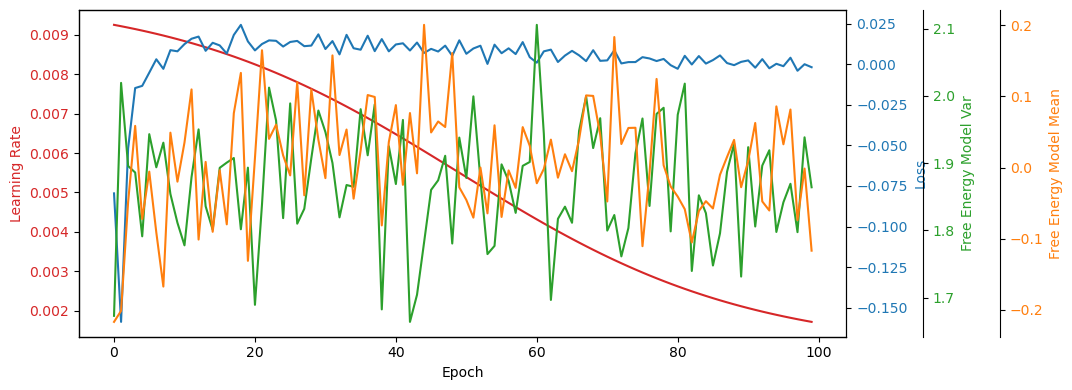

In [30]:
# CELL 7 — plotting training diagnostics

epochs = list(metrics.keys())
loss_vals = [metrics[e]['loss'] for e in epochs]
free_model_mean_vals = [metrics[e]['free_energy_mean'] for e in epochs]
free_model_var_vals = [metrics[e]['free_energy_var'] for e in epochs]
lr_vals = [metrics[e]['lr'] for e in epochs]

fig, ax1 = plt.subplots(figsize=(11, 4))

ax1.plot(epochs, lr_vals, label="Learning Rate", color="tab:red")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Learning Rate", color="tab:red")
ax1.tick_params(axis="y", labelcolor="tab:red")

ax2 = ax1.twinx()
ax2.spines["right"].set_position(("axes", 1.00))
ax2.plot(epochs, loss_vals, label="Amplitude CD Loss", color="tab:blue")
ax2.set_ylabel("Loss", color="tab:blue")
ax2.tick_params(axis="y", labelcolor="tab:blue")

ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
ax3.plot(epochs, free_model_var_vals, label="Free Energy Model Var", color="tab:green")
ax3.set_ylabel("Free Energy Model Var", color="tab:green")
ax3.tick_params(axis="y", labelcolor="tab:green")

ax4 = ax1.twinx()
ax4.spines["right"].set_position(("axes", 1.2))
ax4.plot(epochs, free_model_mean_vals, label="Free Energy Model Mean", color="tab:orange")
ax4.set_ylabel("Free Energy Model Mean", color="tab:orange")
ax4.tick_params(axis="y", labelcolor="tab:orange")

plt.tight_layout()
plt.show()

In [31]:
# CELL 8 — physics metrics: magnetizations + helpers (PyTorch, uses conditioning vector)

def magnetization_z_with_error(samples: torch.Tensor):
    """
    samples: (B,N) with entries in {0,1}
    returns mean |m_z| and SEM
    """
    samples = samples.float()
    spins = 1.0 - 2.0 * samples              # {0,1} -> {+1,-1}
    sample_mags = spins.mean(dim=1).abs()    # (B,)
    mean_mag = sample_mags.mean()
    sem_mag = sample_mags.std(unbiased=True) / math.sqrt(sample_mags.numel())
    return mean_mag, sem_mag


def _free_energy_batch(
        v_batch: torch.Tensor,
        W: torch.Tensor,
        b_batch: torch.Tensor,
        c_batch: torch.Tensor,
) -> torch.Tensor:
    """
    v_batch: (B,N), W: (N,H), b_batch: (B,N), c_batch: (B,H)
    returns: (B,)
    """
    vb_term = (v_batch * b_batch).sum(dim=-1)
    hidden_term = F.softplus(v_batch @ W + c_batch).sum(dim=-1)
    return -vb_term - hidden_term


@torch.no_grad()
def amplitude_ratio_flip(
        model: "ConditionalRBM",
        samples: torch.Tensor,
        cond: torch.Tensor,
        flip_idx: int,
) -> torch.Tensor:
    """
    exp(0.5*(F_ref - F_flip)) per sample, flipping bit at flip_idx

    samples: (B,N) in {0,1}
    cond   : (B, cond_dim) or (B,) if cond_dim == 1
    """
    samples = samples.float()
    B, N = samples.shape

    # Normalize cond shape
    if cond.dim() == 1 and model.cond_dim == 1:
        cond = cond.view(-1, 1)
    if cond.dim() != 2 or cond.shape[0] != B or cond.shape[1] != model.cond_dim:
        raise ValueError(
            f"amplitude_ratio_flip: expected cond shape (B,{model.cond_dim}), got {tuple(cond.shape)}"
        )

    cond = cond.to(samples.device, dtype=torch.float32)

    samples_flip = samples.clone()
    samples_flip[:, flip_idx] = 1.0 - samples_flip[:, flip_idx]

    gamma_b, beta_b, gamma_c, beta_c = model.conditioner(cond)
    b_mod = (1.0 + gamma_b) * model.b.unsqueeze(0) + beta_b
    c_mod = (1.0 + gamma_c) * model.c.unsqueeze(0) + beta_c
    W = model.W

    F_ref  = _free_energy_batch(samples,      W, b_mod, c_mod)
    F_flip = _free_energy_batch(samples_flip, W, b_mod, c_mod)

    return torch.exp(0.5 * (F_ref - F_flip))


@torch.no_grad()
def magnetization_x_with_error(
        model: "ConditionalRBM",
        samples: torch.Tensor,
        cond: torch.Tensor,
) -> Tuple[float, float]:
    """
    Estimates ⟨σ_x⟩ via single-site amplitude ratios.

    samples: (B,N) in {0,1}
    cond   : (B, cond_dim) or (B,) if cond_dim == 1
    """
    samples = samples.float()
    B, N = samples.shape

    # Normalize cond shape
    if cond.dim() == 1 and model.cond_dim == 1:
        cond = cond.view(-1, 1)
    if cond.dim() != 2 or cond.shape[0] != B or cond.shape[1] != model.cond_dim:
        raise ValueError(
            f"magnetization_x_with_error: expected cond shape (B,{model.cond_dim}), got {tuple(cond.shape)}"
        )

    ratios = []
    for i in range(N):
        ratios.append(amplitude_ratio_flip(model, samples, cond, i))

    all_ratios = torch.stack(ratios, dim=1)   # (B, N)
    per_sample_mx = all_ratios.mean(dim=1)    # (B,)

    mean = per_sample_mx.mean()
    sem = per_sample_mx.std(unbiased=True) / math.sqrt(per_sample_mx.numel())
    return float(mean), float(sem)


In [32]:
# CELL 9 — sampling helper (ConditionalRBM + single-parameter 'h')

@torch.no_grad()
def sample_from_model(
        model: ConditionalRBM,
        h: float,
        n: int,
        gen: torch.Generator,
):
    """
    Draw n samples at field h.

    Assumes model.cond_dim == 1 and that this dimension corresponds to 'h'.
    """
    if model.cond_dim != 1:
        raise ValueError("sample_from_model currently assumes cond_dim == 1 (single 'h').")

    cond = torch.full((n, 1), float(h), dtype=torch.float32)
    T_schedule = torch.full((int(model.k),), float(model.T), dtype=torch.float32)

    samples = model.generate(cond, T_schedule, gen)
    return samples.float(), cond


In [33]:
# CELL 10 — evaluation sweep & CSV export

support_h = [1.0, 2.0, 2.8, 3.0, 3.3, 3.6, 4.0, 5.0, 6.0, 7.0]
novel_h   = [1.5, 2.4, 2.6, 2.9, 3.1, 3.2, 3.4, 3.8, 4.5, 5.5, 6.5]

sweep = sorted(
    [(h, "support") for h in support_h]
    + [(h, "novel") for h in novel_h],
    key=lambda x: x[0],
)

csv_file = Path("magnetization.csv")
if not csv_file.exists() or csv_file.stat().st_size == 0:
    with csv_file.open("w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["h", "type", "mag_z", "mag_z_error", "mag_x", "mag_x_error"])

num_samples = 10_000
gen_eval = torch.Generator().manual_seed(1234)

for h, origin in sweep:
    samples, cond = sample_from_model(model, h, num_samples, gen_eval)

    mz, mz_e = magnetization_z_with_error(samples)
    mx, mx_e = magnetization_x_with_error(model, samples, cond)

    print(
        f"h={h:4.1f} [{origin:6}] "
        f"m_z={float(mz):.6f}±{float(mz_e):.6f}  "
        f"m_x={float(mx):.6f}±{float(mx_e):.6f}"
    )

    with csv_file.open("a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            f"{h:.6f}", origin,
            f"{float(mz):.6f}", f"{float(mz_e):.6f}",
            f"{float(mx):.6f}", f"{float(mx_e):.6f}",
        ])

print(f"\nAppended rows to {csv_file.resolve()}")

h= 1.0 [support] m_z=0.961889±0.000971  m_x=0.270278±0.003366
h= 1.5 [novel ] m_z=0.945422±0.001263  m_x=0.314799±0.003506
h= 2.0 [support] m_z=0.818889±0.002357  m_x=0.559410±0.003467
h= 2.4 [novel ] m_z=0.690711±0.002892  m_x=0.720024±0.003182
h= 2.6 [novel ] m_z=0.632578±0.003000  m_x=0.779962±0.002961
h= 2.8 [support] m_z=0.580911±0.003026  m_x=0.828157±0.002688
h= 2.9 [novel ] m_z=0.549222±0.003038  m_x=0.854010±0.002549
h= 3.0 [support] m_z=0.528778±0.003006  m_x=0.870967±0.002417
h= 3.1 [novel ] m_z=0.518400±0.002980  m_x=0.879774±0.002302
h= 3.2 [novel ] m_z=0.492667±0.002937  m_x=0.899338±0.002148
h= 3.3 [support] m_z=0.481444±0.002917  m_x=0.906668±0.002041
h= 3.4 [novel ] m_z=0.461378±0.002875  m_x=0.920516±0.001916
h= 3.6 [support] m_z=0.441800±0.002789  m_x=0.934446±0.001735
h= 3.8 [novel ] m_z=0.425911±0.002764  m_x=0.943013±0.001620
h= 4.0 [support] m_z=0.408933±0.002694  m_x=0.952985±0.001473
h= 4.5 [novel ] m_z=0.382067±0.002569  m_x=0.967571±0.001218
h= 5.0 [support] 